In [4]:
import os, zipfile, shutil
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists, splitext

import sys
import numpy as np
import tensorflow as tf
import sys
import pandas as pd


from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib inline

import seaborn as sns

import cardio
# import cardio.dataset as ds
import cardio.batchflow as bf
from cardio import EcgBatch, EcgDataset

from scipy.stats import beta

from cardio.batchflow import B, V, F
from cardio.models.dirichlet_model import DirichletModel, concatenate_ecg_batch
from cardio.models.metrics import f1_score, classification_report, confusion_matrix, auc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Testing

In [ ]:
# shutil.make_archive('All WFDB full LD', 'zip', SIGNALS_PATH )

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [6]:
SIGNALS_PATH = "/home/kate/Research/Raw Data/All WFDB full LD/"
SIGNALS_MASK = SIGNALS_PATH + "*.hea"
MODEL_PATH = '/home/kate/Research/dirichlet_model'
LABELS_PATH = SIGNALS_PATH + "REFERENCE full LD.csv"

BATCH_SIZE = 256

In [7]:
eds = EcgDataset(path=SIGNALS_MASK, no_ext=True, sort=True)
# eds.cv_split()

In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "build": False,
    "load": {"path": MODEL_PATH},
}

In [9]:
test_ppl = (
    bf.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .load(components="target", fmt="csv", src=LABELS_PATH)
#       .drop_labels(["N"])
      .rename_labels({"D": "A", "ND": "NO"})
      .band_pass_signals(low=2.5, high=25)
      .flip_signals()
      .split_signals(2048, 2048)
      .binarize_labels()
#        .drop_short_signals(4000)
#        .random_split_signals(3000, 3)
      .predict_model("dirichlet", make_data=concatenate_ecg_batch,
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

test_ppl = (eds >> test_ppl).run()

INFO:tensorflow:Restoring parameters from /home/kate/Research/dirichlet_model/model-26000


In [10]:
predictions = test_ppl.get_variable("predictions_list")

In [12]:
# print(metrics.evaluate('accuracy'))

In [13]:
print(classification_report(predictions))

              precision    recall  f1-score   support

           A       0.11      0.03      0.05       266
          NO       0.93      0.98      0.96      3703

   micro avg       0.92      0.92      0.92      3969
   macro avg       0.52      0.51      0.50      3969
weighted avg       0.88      0.92      0.90      3969



In [14]:
f1_score(predictions)

0.504409874708394

In [15]:
confusion_matrix(predictions)

True,A,NO,All
Pred,,,
A,9,71,80
NO,257,3632,3889
All,266,3703,3969


In [16]:
pd.options.display.float_format = '{:.2f}'.format

a = []
for i in range(len(predictions)):
    val =predictions[i]['target_pred']['A']
#     print(val)
    a.append(val)

pred_proba = pd.DataFrame(a, index=eds.indices, columns=['AF prob'])

true_labels = (pd.read_csv(LABELS_PATH, index_col=0, names=['True label'])
               .replace(['N', 'ND'], 'NO'))
true_labels = true_labels.replace('D', 'A')

df = pd.merge(pred_proba, true_labels, how='left', left_index=True, right_index=True)
df.head(10)

,AF prob,True label
10_Bsk_1_A1_opt,0.02,NO
10_Bsk_1_A2_opt,0.02,NO
10_Bsk_1_A3_opt,0.02,NO
10_Bsk_1_A4_opt,0.02,NO
10_Bsk_1_A5_opt,0.02,NO
10_Bsk_1_A6_opt,0.02,NO
10_Bsk_1_A7_opt,0.02,NO
10_Bsk_1_A8_opt,0.02,NO
10_Bsk_1_B1_opt,0.02,NO
10_Bsk_1_B2_opt,0.02,NO


In [17]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print(balanced_accuracy_score((df['True label'] == 'A').astype(int),
                            (df['AF prob'].astype(float) >= 0.5).astype(int)))

0.5073304717369984


In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, thresholds = roc_curve((df['True label']=='A').astype(int), df['AF prob'], pos_label=1)
roc_auc = roc_auc_score((df['True label']=='A').astype(int), df['AF prob'])
roc_auc

0.4797720401462744

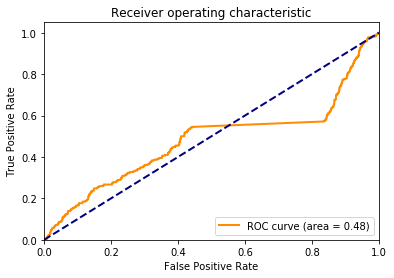

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('../Research/roc_auc.png', format='png')
plt.show()


In [37]:
q = 90
uncertainty = [d["uncertainty"] for d in predictions]
thr = np.percentile(uncertainty, q)
certain_predictions = [d for d in predictions if d["uncertainty"] <= thr]

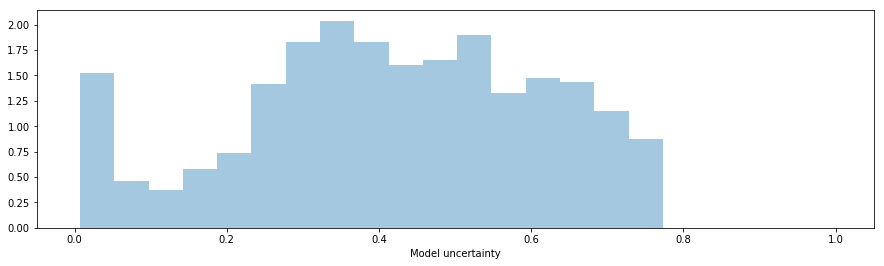

In [38]:
uncertainty = [d["uncertainty"] for d in predictions]

fig = plt.figure(figsize=(15, 4))
sns.distplot(uncertainty, hist=True, norm_hist=True, kde=False)
plt.xlabel("Model uncertainty")
plt.xlim(-0.05, 1.05)
plt.show()

# Predictions

In [31]:
from functools import partial

In [6]:
import zipfile 
zip = zipfile.ZipFile('dirichlet_model.zip')
zip.extractall()

In [26]:
SIGNALS_PATH = "/home/kate/Research/training2017/"
MODEL_PATH = '/home/kate/Research/dirichlet_model'

BATCH_SIZE = 100

In [14]:
os.listdir('/home/kate/Research/dirichlet_model/')

['attrs.json',
 'checkpoint',
 'model-26000.data-00000-of-00001',
 'model-26000.index',
 'model-26000.meta']

In [15]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "build": False,
    "load": {"path": MODEL_PATH},
}

In [32]:
template_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
    
)

INFO:tensorflow:Restoring parameters from /home/kate/Research/dirichlet_model/model-26000


In [33]:
signal_name = "A00001.hea"
signal_path = SIGNALS_PATH + signal_name
predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
predict_ppl = (predict_eds >> template_predict_ppl).run()

In [34]:
predict_ppl.get_variable("predictions_list")

[{'target_pred': {'A': 0.021257801, 'NO': 0.97874224},
  'uncertainty': 0.007573604583740234}]

In [35]:
template_full_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("signals", init_on_each_run=list)
      .init_variable("predictions_list", init_on_each_run=list)
      .init_variable("parameters_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .update_variable("signals", value=B("signal"))
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches=["predictions", "parameters"],
                     save_to=[V("predictions_list"), V("parameters_list")], mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

INFO:tensorflow:Restoring parameters from /home/kate/Research/dirichlet_model/model-26000


In [36]:
def predict_and_visualize(signal_path):
    predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
    
    full_predict_ppl = (predict_eds >> template_full_predict_ppl).run()
    signal = full_predict_ppl.get_variable("signals")[0][0][0][:2000].ravel()
    predictions = full_predict_ppl.get_variable("predictions_list")[0]
    parameters = full_predict_ppl.get_variable("parameters_list")[0]
    
    print(predictions)

    x = np.linspace(0.001, 0.999, 1000)
    y = np.zeros_like(x)
    for alpha in parameters:
        y += beta.pdf(x, *alpha)
    y /= len(parameters)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2.5, 1]}, figsize=(15, 4))

    ax1.plot(signal)

    ax2.plot(x, y)
    ax2.fill_between(x, y, alpha=0.3)
    ax2.set_ylim(ymin=0)

    plt.show()

{'uncertainty': 0.007573604583740234, 'target_pred': {'A': 0.021257801, 'NO': 0.97874224}}


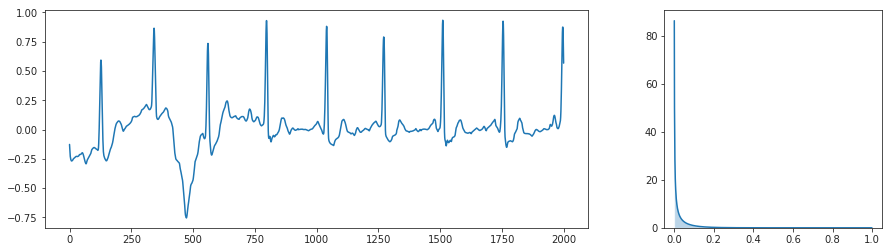

In [43]:
predict_and_visualize(SIGNALS_PATH + "A00001.hea")

{'uncertainty': 0.4200456142425537, 'target_pred': {'A': 0.19596615, 'NO': 0.8040339}}


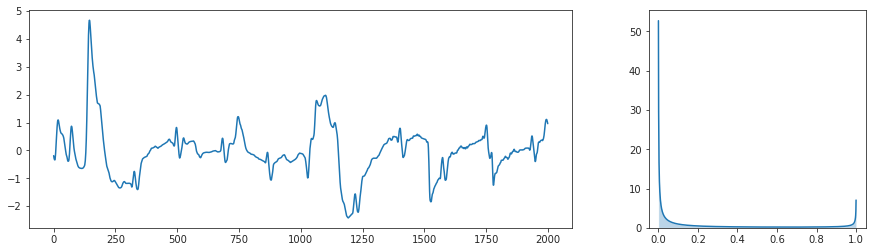

In [42]:
predict_and_visualize(SIGNALS_PATH + "A01505.hea")

# Electrodes

In [128]:
SIGNALS_PATH = "/home/kate/Research/Raw Data/All WFDB/"
MODEL_PATH = '/home/kate/Research/dirichlet_model'
LABELS_PATH = SIGNALS_PATH + "REFERENCE.csv"

BATCH_SIZE = 100

In [129]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "build": False,
    "load": {"path": MODEL_PATH},
}

In [140]:
template_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .band_pass_signals(low=1, high=20)
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
    
)

INFO:tensorflow:Restoring parameters from /home/kate/Research/dirichlet_model/model-26000


In [141]:
names = os.listdir(SIGNALS_PATH)
for name in names:
    if name.endswith('.dat'):
        names.remove(name) 

In [142]:
signal_name = names[1]
signal_path = SIGNALS_PATH + signal_name
predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
predict_ppl = (predict_eds >> template_predict_ppl).run()

In [143]:
predict_ppl.get_variable("predictions_list")

[{'target_pred': {'A': 0.19774394, 'NO': 0.802256},
  'uncertainty': 0.36562466621398926}]

In [144]:
pd.read_csv(LABELS_PATH).head()

,H72_F75_Electrode_KH_OM_KH_Bsk_2_C7,D
0,H72_F75_Electrode_KH_OM_KH_Bsk_2_C8,D
1,H72_F75_Electrode_KH_OM_KH_Bsk_2_D7,D
2,H72_F75_Electrode_KH_OM_KH_Bsk_2_D8,D
3,H79_F108_csv_annot_OM_KH_Bsk_1_B5,D
4,H79_F108_csv_annot_OM_KH_Bsk_1_C5,D


In [145]:
batch = predict_eds.next_batch(1, unique_labels=['N', 'D', 'ND'])

In [146]:
batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

In [147]:
batch_with_data = batch_with_data.load(src=LABELS_PATH, fmt='csv', components='target')

In [148]:
batch_with_data.target

array(['ND'], dtype=object)

In [114]:
template_full_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("signals", init_on_each_run=list)
      .init_variable("predictions_list", init_on_each_run=list)
      .init_variable("parameters_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .update_variable("signals", value=B("signal"))
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches=["predictions", "parameters"],
                     save_to=[V("predictions_list"), V("parameters_list")], mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

INFO:tensorflow:Restoring parameters from /home/kate/Research/dirichlet_model/model-26000


In [115]:
def predict_and_visualize(signal_path):
    predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
    
    full_predict_ppl = (predict_eds >> template_full_predict_ppl).run()
    signal = full_predict_ppl.get_variable("signals")[0][0][0][:2000].ravel()
    predictions = full_predict_ppl.get_variable("predictions_list")[0]
    parameters = full_predict_ppl.get_variable("parameters_list")[0]
    
    print(predictions)

    x = np.linspace(0.001, 0.999, 1000)
    y = np.zeros_like(x)
    for alpha in parameters:
        y += beta.pdf(x, *alpha)
    y /= len(parameters)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2.5, 1]}, figsize=(15, 4))

    ax1.plot(signal)

    ax2.plot(x, y)
    ax2.fill_between(x, y, alpha=0.3)
    ax2.set_ylim(ymin=0)

    plt.show()

{'uncertainty': 0.3939533233642578, 'target_pred': {'A': 0.20375507, 'NO': 0.7962449}}


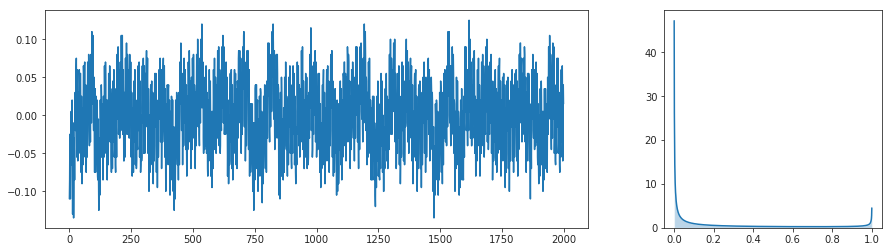

In [149]:
signal_name = names[1]
signal_path = SIGNALS_PATH + signal_name
predict_and_visualize(signal_path)

In [124]:
print(signal_path)

/home/kate/Research/Raw Data/All WFDB/H79_F108_csv_annot_OM_KH_Bsk_1_E5.hea
